# ФИНАЛЬНЫЙ ПРОЕКТ                                                                     ВАРИАНТ 1

# 1.В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

In [4]:
import pandas as pd

In [5]:
reg=pd.read_csv('shared/problem1-reg_data.csv', sep=';')

In [6]:
reg.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [7]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [8]:
auth=pd.read_csv('shared/problem1-auth_data.csv', sep=';')

In [9]:
auth.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [10]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Сейчас данные о времени регистрации и информация о времени захода представляет собой данные вида Int64 и показывают количество секунд, прошедших с 1 января 1970 года. На мой взгляд, это не очень удобно для дальнейшей работы, поэтому преобразуем данные в вид год-месяц-день часы-минуты-секунды, а сами данные в datetime64[ns].

In [11]:
reg['reg_date'] = pd.to_datetime(reg['reg_ts'], unit='s')
reg.head(5)

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,947802447,3,2000-01-13 22:27:27
3,959523541,4,2000-05-28 14:19:01
4,969103313,5,2000-09-16 11:21:53


In [12]:
auth['auth_date']= pd.to_datetime(auth['auth_ts'], unit ='s')
auth.head(5)

,auth_ts,uid,auth_date
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46
3,933393015,2,1999-07-31 03:50:15
4,933875379,2,1999-08-05 17:49:39


Retention — это метрика, которая показывает, сколько пользователей вернулись в приложение или игру после первой регистрации. Обычно ее измеряют на определенные временные интервалы, например, через 1 день, 7 дней, 30 дней, 365 дней и т.д.. Предлагаю рассмотреть именно такие временные границы.

Для создания функции ограничимся лишь частью данных (выберем сэмпл), так как данных слишком много, и питон может устать :(

In [13]:
reg_sample=reg.head(1000)
reg_sample

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,947802447,3,2000-01-13 22:27:27
3,959523541,4,2000-05-28 14:19:01
4,969103313,5,2000-09-16 11:21:53
...,...,...,...
995,1237760229,1107,2009-03-22 22:17:09
996,1237812904,1108,2009-03-23 12:55:04
997,1237865526,1109,2009-03-24 03:32:06
998,1237918095,1110,2009-03-24 18:08:15


In [14]:
auth_sample=auth[auth['uid'].isin(reg_sample.uid.unique())]
auth_sample

,auth_ts,uid,auth_date
0,911382223,1,1998-11-18 09:43:43
1,932683089,2,1999-07-22 22:38:09
2,932921206,2,1999-07-25 16:46:46
3,933393015,2,1999-07-31 03:50:15
4,933875379,2,1999-08-05 17:49:39
...,...,...,...
9591373,1600818619,280,2020-09-22 23:50:19
9592290,1600823481,925,2020-09-23 01:11:21
9594450,1600835444,224,2020-09-23 04:30:44
9596809,1600848660,890,2020-09-23 08:11:00


Будем рассчитывать показатель retention не по дням, а по месяцам. 

In [15]:
def calculate_monthly_retention(reg_df, auth_df, retention_days):
    reg_df['reg_month'] = reg_df['reg_date'].dt.to_period('M')
    
    # Создаем DataFrame для хранения результатов
    retention_results = pd.DataFrame(index=reg_df['reg_month'].unique(), columns=retention_days)
    
    # Группируем по месяцу регистрации
    monthly_groups = reg_df.groupby('reg_month')['uid'].unique().apply(set).reset_index()
    
    for index, row in monthly_groups.iterrows():
        reg_month = row['reg_month']
        registered_users = row['uid']
        
        for days in retention_days:
            # Вычисляем дату, до которой нужно проверять авторизацию
            retention_start_date = reg_month.start_time
            retention_end_date = retention_start_date + pd.Timedelta(days=days)
            
            # Получаем uid пользователей, которые авторизовались в указанный период
            returning_users = auth_sample[(auth_df['auth_date'] > retention_start_date) & 
                                          (auth_df['auth_date'] <= retention_end_date)]['uid'].unique()
            
            # Считаем количество вернувшихся пользователей
            retention_count = len(set(registered_users) & set(returning_users))
            
            # Вычисляем retention rate
            if len(registered_users) > 0:
                retention_rate = retention_count / len(registered_users)
            else:
                retention_rate = 0
            
            # Записываем результат в DataFrame
            retention_results.at[reg_month, days] = retention_rate
    
    retention_results.fillna(0, inplace=True)
    return retention_results
# Проверим работу функции на наших выборках
reg_df=reg_sample
auth_df=auth_sample
retention_days = [1, 7, 30, 365] 
retention_results = calculate_monthly_retention(reg_df, auth_df, retention_days)
retention_results


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,1,7,30,365
1998-11,0.000000,0.000000,1.000000,1.0
1999-07,0.000000,0.000000,1.000000,1.0
2000-01,0.000000,0.000000,1.000000,1.0
2000-05,0.000000,0.000000,1.000000,1.0
2000-09,0.000000,0.000000,1.000000,1.0
...,...,...,...,...
2008-11,0.025000,0.225000,1.000000,1.0
2008-12,0.023256,0.209302,0.976744,1.0
2009-01,0.043478,0.217391,0.956522,1.0
2009-02,0.023256,0.255814,1.000000,1.0


Таким образом, данной функцией можно пользоваться для расчета ежемесячного значения Retention Rate в любых временных рамках (retention_days), а также беря не только срезы датасетов, но и генеральную совокупность.

# 2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

# Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [16]:
ab_df=pd.read_csv('Проект_1_Задание_2.csv', sep=';')
ab_df.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [17]:
ab_df.shape

(404770, 3)

In [18]:
# Проверим, что у нас не повторяются чьи-то айди в данных.
ab_df.user_id.nunique()

404770

In [19]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [20]:
ab_df.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [21]:
a=ab_df.query('testgroup=="a"')
arpu_a=a.revenue.mean()
arpu_a

25.413719736965806

In [22]:
b=ab_df.query('testgroup=="b"')
arpu_b=b.revenue.mean()
arpu_b

26.75128659327863

In [23]:
((arpu_b-arpu_a)/arpu_a)*100
#Проверяем, что ARPU тестовой группы выше на 5%, чем у контрольной. Делаем вывод, что группа "a" - контрольная, а "b" - тестовая. (мало ли)

5.263168360069894

In [24]:
a.revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [25]:
b.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [26]:
# Сразу в глаза бросается большая разница стандартных отклонений в группах, а также наличие выброса в контрольной группе :
# максимальная покупка - 37433, в то время как у тестовой лишь 4000,
# это может говорить о постоянном/постоянных покупателях попавших в контрольную группу, что немного искажает реальное положение вещей.

In [27]:
# Попробуем выкинуть этого покупателя из контрольной группы и посмотрим, что получится
user_id_to_exclude=a.query('revenue == "37433"')['user_id'].values[0]
a_new=a.query('user_id != @user_id_to_exclude')
a_new.revenue.describe() #и снова максимальное значение – это выброс. Проверим данные внимательнее

count    202102.000000
mean         25.228627
std         917.002847
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37407.000000
Name: revenue, dtype: float64

In [28]:
# Отберём только тех пользователей, которые сколько-то заплатили, чтобы посмотреть на данные поближе
import matplotlib.pyplot as plt
b_plat=b.query('revenue != "0"') 
b_plat.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


Text(0.5, 1.0, 'Распределение выручки от пользователей среди тестовой группы')

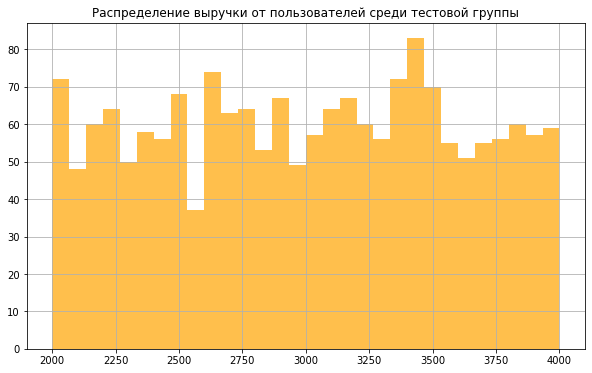

In [85]:
plt.figure(figsize=(10, 6))
b_plat.revenue.hist(color='orange', alpha=0.7, bins=30)
plt.title('Распределение выручки от пользователей среди тестовой группы')

In [30]:
a_plat=a.query('revenue != "0"')
a_plat.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


Text(0.5, 1.0, 'Распределение выручки от пользователей среди контрольной группы')

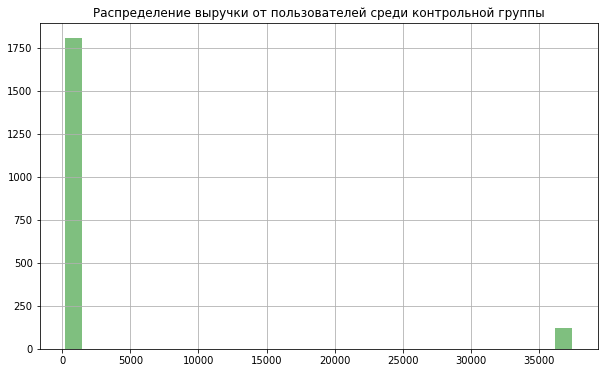

In [84]:
plt.figure(figsize=(10, 6))
a_plat.revenue.hist(color='green', alpha=0.5, bins=30)
plt.title('Распределение выручки от пользователей среди контрольной группы')

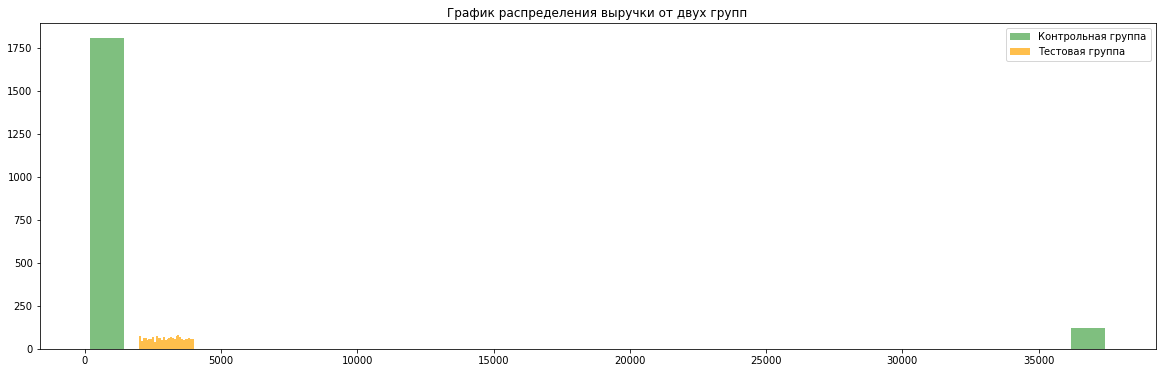

In [96]:
plt.figure(figsize=(20, 6))
plt.hist(a_plat['revenue'], bins=30, alpha=0.5, color='green', label='Контрольная группа')
plt.hist(b_plat['revenue'], bins=30, alpha=0.7, color='orange', label='Тестовая группа')
plt.title('График распределения выручки от двух групп')
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Ящик с усами. Контрольная группа')

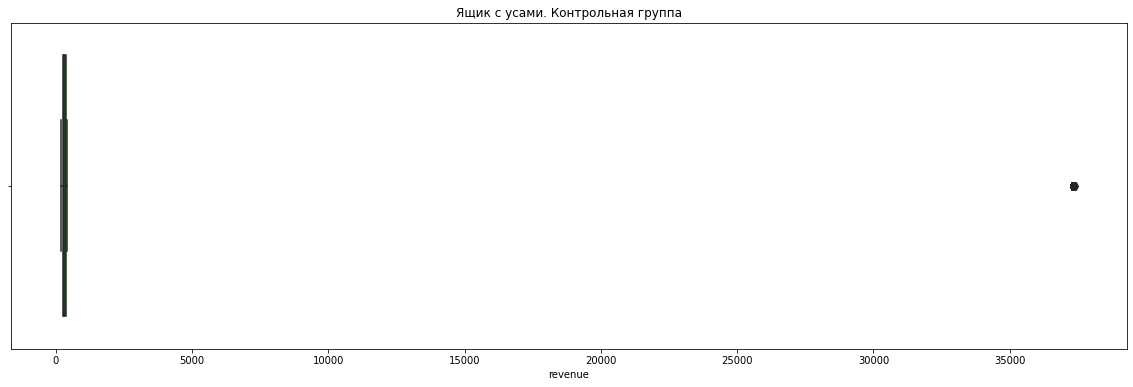

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
sns.boxplot(x=a_plat['revenue'], color='green')
plt.title('Ящик с усами. Контрольная группа')
# Получили очень странную картину. Технически, то, что мы видим справа – это выбросы.

Text(0.5, 1.0, 'Ящик с усами. Тестовая группа')

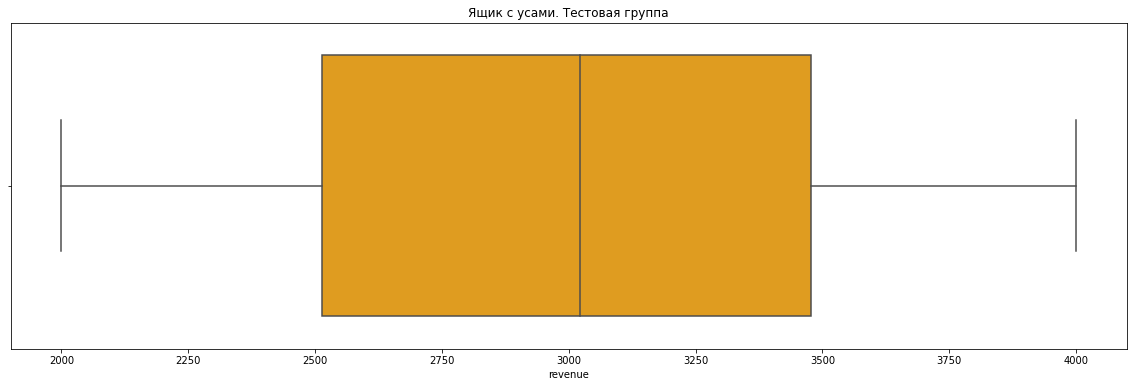

In [92]:
plt.figure(figsize=(20, 6))
sns.boxplot(x=b_plat['revenue'], color='orange')
plt.title('Ящик с усами. Тестовая группа')

In [98]:
# Убираем выбросы. В наших данных о контрольной группе имеется 123 пользователя, выручка от которых больше 37 000, но меньше 38 000.
# От остальных же выручка меньше 400.
# Мне кажется это очень странным, и тут может быть большое пространство для интерпретаци, вплоть до обычных ошибок в данных.
# Но я буду считать, что её нет. 
a_plat_poor=a_plat.query('revenue < 37000')
a_plat_poor.revenue.describe()
# В итоге у нас остается 1805 пользователей, а выручка от них всего 545,937.
# До удаления 123 пользователей из списка выручка от контрольной группы составляла 5,136,189. Показатели ОЧЕНЬ сильно поменялись. 
# Просто так удалить 123 пользователей нельзя.
# Выручка от тестовой группы тем временем составляет 5,421,603.

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Ящик с усами. Контрольная группа – платящие "немного"')

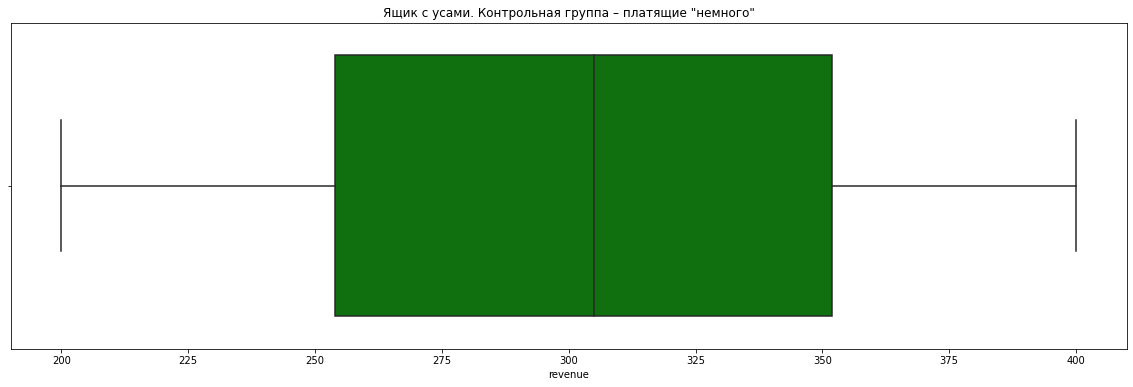

In [104]:
plt.figure(figsize=(20, 6))
sns.boxplot(x=a_plat_poor['revenue'], color='green')
plt.title('Ящик с усами. Контрольная группа – платящие "немного"')

In [37]:
# Теперь посмотрим на часть пользователей из контрольной группы, которых мы посчитали за выбросы.
# Рассмотрим их как отдельную группу под названием rich.

a_rich=a_plat.query('revenue>37000')
a_rich.revenue.describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Ящик с усами. Контрольная группа – платящие "много"')

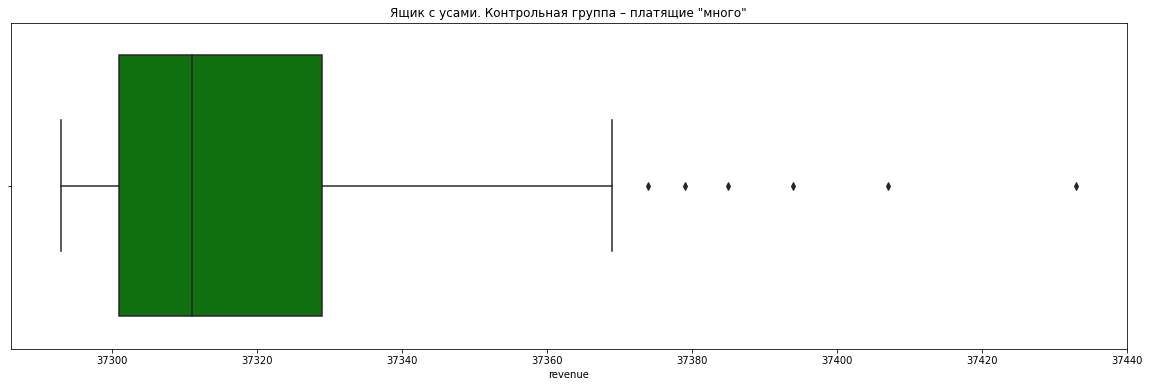

In [106]:
plt.figure(figsize=(20, 6))
sns.boxplot(x=a_rich['revenue'], color='green')
plt.title('Ящик с усами. Контрольная группа – платящие "много"')
# Здесь тоже есть некоторые выбросы, однако они уже не так критичны, 
# поскольку все платежи из этой группы уместились в промежутке от 37,293 до 37,433 у.е.  

###### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Давайте рассчитаем самые базовые метрики и ещё раз посмотрим на цифры:

##### ARPU

In [39]:
# arpu_a=a.revenue.mean()
# arpu_b=b.revenue.mean()

Контрольная группа (a): ARPU = 25,41
Тестовая группа (b): ARPU = 26.75

##### Conversion rate

In [40]:
# conv_rate_a=((a.query('revenue != "0"').shape[0]/a.shape[0])*100)
# conv_rate_b=((b.query('revenue != "0"').shape[0]/b.shape[0])*100)

Контрольная группа (a): Conversion rate = 0.954%
Тестовая группа (b): Conversion rate = 0.891%

##### Общая выручка

In [41]:
# rev_a=a.revenue.sum()
# rev_b=b.revenue.sum()

Контрольная группа (a): total_revenue = 5,136,189
Тестовая группа (b): total_revenue = 5,421,603

###### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Проведём тест хи-квадрат, чтобы установить, статистически ли значимы различия в наших конверсиях. Уровень значимости: 5%

In [42]:
import scipy.stats as stats


control_paid = 1928
control_total = 202103
test_paid = 1805
test_total = 202667


data = [[control_paid, control_total - control_paid],
        [test_paid, test_total - test_paid]]

# Хи-квадрат тест
chi2, p, dof, expected = stats.chi2_contingency(data)

print(f"p-value: {p}")



p-value: 0.03647561892312613


Вывод: Различия стат.значимы ( p < 0.05 )

##### Наши данные о выручке по группам распределены ненормально (очевидно по графикам + провела тест Шапиро-Уилка), поэтому в качестве стат.теста для анализа метрики ARPU воспользуемся тестом Манна-Уитни 

In [43]:
import numpy as np
from scipy import stats
group_a = ab_df[ab_df['testgroup'] == 'a']['revenue']
group_b = ab_df[ab_df['testgroup'] == 'b']['revenue']
u_statistic, p_value = stats.mannwhitneyu(group_a, group_b)
print(f"Mann-Whitney U test: U-statistic={u_statistic}, p-value={p_value}")

Mann-Whitney U test: U-statistic=20491259376.0, p-value=0.06269701316074398


Вывод: Мы не можем делать вывод о стат.значимости различий медиан доходов(revenue) от обеих групп пользователей (контрольной и тестовой) при уровне значимости 5%.

##### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Меня интересует вопрос аномальных пользователей в контрольной группе, попробуем понять, есть ли у них что-то общее

In [44]:
ab_df=ab_df.rename(columns={'user_id':'uid'})

In [45]:
reg_date_df=reg[['uid', 'reg_date']]
reg_date_df

,uid,reg_date
0,1,1998-11-18 09:43:43
1,2,1999-07-22 22:38:09
2,3,2000-01-13 22:27:27
3,4,2000-05-28 14:19:01
4,5,2000-09-16 11:21:53
...,...,...
999995,1110618,2020-09-23 15:13:54
999996,1110619,2020-09-23 15:14:46
999997,1110620,2020-09-23 15:15:39
999998,1110621,2020-09-23 15:16:31


In [46]:
ab_reg=ab_df.merge(reg_date_df, on='uid')

In [47]:
a_reg=ab_reg.query('testgroup=="a"')
a_reg_rich=a_reg.query('revenue > 37000')
a_reg_rich

,uid,revenue,testgroup,reg_date
376,417,37324,a,2007-08-11 01:53:06
4026,4429,37304,a,2011-07-20 00:24:25
5231,5778,37315,a,2011-12-26 04:13:36
7304,8066,37307,a,2012-07-16 02:51:36
7908,8744,37334,a,2012-09-02 10:11:45
...,...,...,...,...
324715,360697,37347,a,2018-11-09 14:24:08
340962,378669,37297,a,2018-12-09 06:59:22
350577,389342,37298,a,2018-12-26 04:52:27
355310,394581,37302,a,2019-01-03 08:36:03


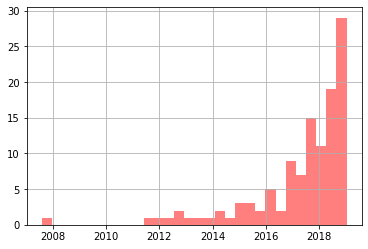

In [111]:
a_reg_rich.reg_date.hist(color='red', alpha=0.5, bins=30)

In [49]:
a_reg_poor=a_reg.query('revenue < 37000')
a_reg_poor

,uid,revenue,testgroup,reg_date
1,2,0,a,1999-07-22 22:38:09
2,3,0,a,2000-01-13 22:27:27
9,10,0,a,2001-09-20 02:07:54
10,11,0,a,2001-11-12 01:05:37
11,12,0,a,2001-12-30 17:20:43
...,...,...,...,...
364545,404761,0,a,2019-01-18 23:06:22
364547,404763,0,a,2019-01-18 23:11:10
364550,404766,0,a,2019-01-18 23:18:23
364552,404768,231,a,2019-01-18 23:23:11


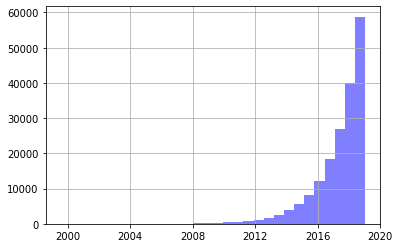

In [112]:
a_reg_poor.reg_date.hist(color='blue', alpha=0.5, bins=30)

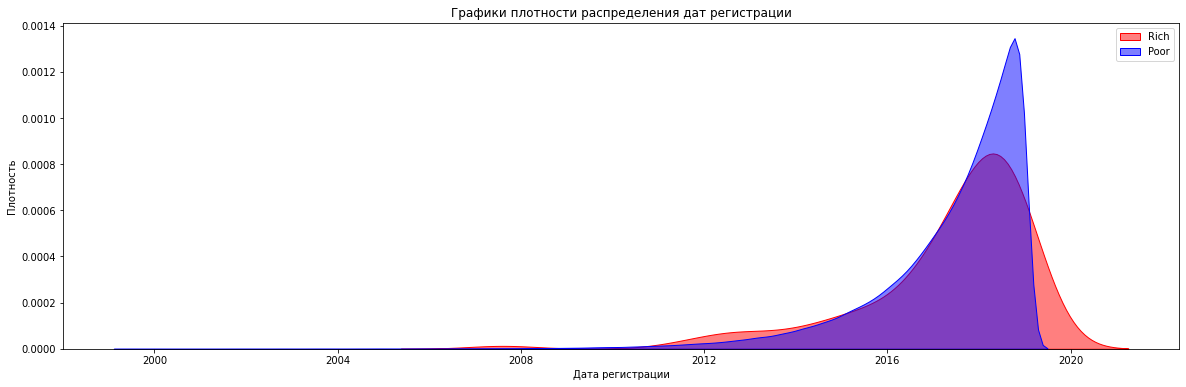

In [113]:
plt.figure(figsize=(20, 6))

sns.kdeplot(a_reg_rich['reg_date'], color='red', label='Rich', fill=True, alpha=0.5)
sns.kdeplot(a_reg_poor['reg_date'], color='blue', label='Poor', fill=True, alpha=0.5)

plt.title('Графики плотности распределения дат регистрации')
plt.xlabel('Дата регистрации')
plt.ylabel('Плотность')
plt.legend(loc='upper right')
plt.show()

Вывод: влияние даты регистрации на количество выручки, получаемой с пользователя не велико. Таким образом я отвергла свою теорию о том, что свыше 37000 мы получаем от старых преданных пользователей, к примеру.

Теперь можно посмотреть, есть ли различия в контрольной и тестовой группе по датам регистрации.

In [52]:
ab_reg

,uid,revenue,testgroup,reg_date
0,1,0,b,1998-11-18 09:43:43
1,2,0,a,1999-07-22 22:38:09
2,3,0,a,2000-01-13 22:27:27
3,4,0,b,2000-05-28 14:19:01
4,5,0,b,2000-09-16 11:21:53
...,...,...,...,...
364550,404766,0,a,2019-01-18 23:18:23
364551,404767,0,b,2019-01-18 23:20:47
364552,404768,231,a,2019-01-18 23:23:11
364553,404769,0,a,2019-01-18 23:25:35


In [53]:
b_reg=ab_reg.query('testgroup=="b"')
b_reg

,uid,revenue,testgroup,reg_date
0,1,0,b,1998-11-18 09:43:43
3,4,0,b,2000-05-28 14:19:01
4,5,0,b,2000-09-16 11:21:53
5,6,0,b,2000-12-19 06:14:55
6,7,0,b,2001-03-10 11:11:11
...,...,...,...,...
364546,404762,0,b,2019-01-18 23:08:46
364548,404764,0,b,2019-01-18 23:13:34
364549,404765,0,b,2019-01-18 23:15:58
364551,404767,0,b,2019-01-18 23:20:47


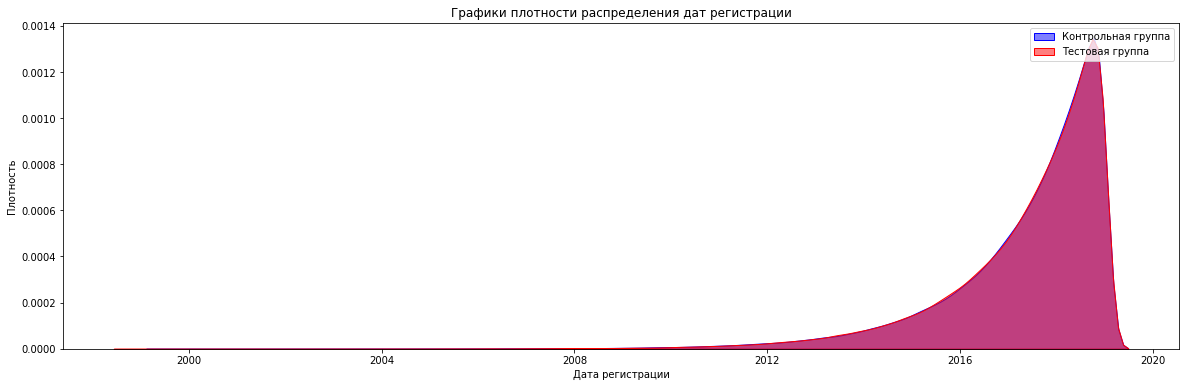

In [54]:
plt.figure(figsize=(20, 6))

sns.kdeplot(a_reg['reg_date'], color='blue', label='Контрольная группа', fill=True, alpha=0.5)
sns.kdeplot(b_reg['reg_date'], color='red', label='Тестовая группа', fill=True, alpha=0.5)

plt.title('Графики плотности распределения дат регистрации')
plt.xlabel('Дата регистрации')
plt.ylabel('Плотность')
plt.legend(loc='upper right')
plt.show()

Нет, разницы нет, похоже, выборки были сделаны случайно.

##### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ВЫВОДЫ:

Результаты неоднозначны. У контрольной группы и тестовой не сильно различаются показатели средней выручки, конверсий и в целом разных метрик, однако сам характер распределения выручки по пользователям меняется кардинально. Анализируя данные, у меня не получилось разобраться в причинах таких изменений, возможно, для этого требуется дополнительная информация о компании, о пользователях мобильной игры, а также о характеристиках акционных предложений. Если делать вывод, то моя логика подсказывает, что компании лучше, если её важнейшие показатели зависят не всего лишь от сотни человек, которые платят сверхмного (123 таких человека в контрольной группе, 123 человека – это 6,4% от всех платящих пользователей из этой группы), а когда выручка распределена относительно равномерно среди всех платящих игроков, в таком случае положение становится более устойчивым. К тому же различия в конверсиях оказались стат.значимы, следовательно акционное предложение тестовой группы лучше стимулирует игроков на покупки. Таким образом, я считаю набор предложений для тестовой группы лучшим, однако принятие решение очень зависит и от сторонних факторов, таких как стратегический менеджмент мобильного приложения и других. 

# 3. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события? Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Существует множество простых и множество сложных метрик для оценки результатов события, я же предлагаю следующие:

1.   Участие в событии:
   - Количество игроков, принявших участие в событии.
   - Доля активных игроков, принявших участие в событии (предварительно необходимо определить понятие "активных игроков", например, те, кто заходят в игру  не меньше 1 раза в неделю).
   - Доля новичков, участвующих в событии (предварительно определить понятие "новичок", например, пользователи, зарегистрировавшиеся не ранее чем за неделю до события).


2. Успешность прохождения:
   - Процент игроков, завершивших событие полностью ((количество завершивших / количество участвующих)*100%).
   - Средний уровень, до которого игроки дошли в событии ((сумма значений уровня, до которого дошел пользователь / количество участвующих)*100%).

3. Частота попыток:
   - Среднее количество попыток на игрока для завершения всех уровней события.
   - Количество попыток, которые потребовались игрокам для прохождения отдельных уровней.

4. Время прохождения:
   - Среднее время, затраченное на завершение события.
   - Среднее время прохождения одного уровня.

5. Монетизация и вовлеченность:
   - Количество и сумма внутриигровых покупок, совершённых во время события (например, для покупки дополнительных попыток или усилений).
   - Изменение вовлеченности игроков (например, частота входа в игру) на период события.



Если механика события усложнится, и при каждой неудачной попытке игрок будет откатываться назад, это может повлиять на набор метрик. Ключевые изменения:


1. Частота неудачных попыток:
   - Количество неудачных попыток до завершения события может значительно возрасти.
   - Среднее количество откатов на игрока. Это новая метрика, которая будет показывать, сколько раз игроки откатывались назад.

2. Продолжительность прохождения:
   - Среднее время завершения события может увеличиться из-за усложненной механики.
   - Время, проведенное на каждом уровне, также может измениться, так как игрокам потребуется больше попыток.

3. Уровень прогресса игроков:
   - Поскольку откаты затрудняют прохождение, метрика среднего уровня, до которого дошли игроки, может снизиться.
   - Количество игроков, не завершивших событие, также может увеличиться, что отразится на проценте успешности.

4. Частота внутриигровых покупок:
   - Можно ожидать увеличение покупок усилений, дополнительных жизней или попыток, так как игрокам потребуется больше ресурсов для преодоления уровня.

5. Отказ от события:
   - Показатель отказа (доля игроков, которые прекратили участие в событии из-за его сложности) может вырасти, и это стоит отслеживать, чтобы понять влияние усложненной механики на удержание игроков.